**Course organisers**

Jan Grohn (jan.grohn@psy.ox.ac.uk), Miriam Klein-Flügge (miriam.klein-flugge@psy.ox.ac.uk)  


# Introduction and recap
**Aims for today’s session:**
- Develop the computational model further to include both learning and decision-making
- Understand how you can validate your model using simulations

To get started, run the next code cell that loads in the required libraries and sets some global parameters.

In [ ]:
#@title ## Import libraries

# numpy is a libarary used to do all kinds of mathematical operations
import numpy as np

# pandas allows us to organise data as tables (called "dataframes")
import pandas as pd

# this allows us to make interactive figures
from google.colab import output
output.enable_custom_widget_manager()

# seed the random number genrator
rng = np.random.default_rng(12345)

# load in some custom functions for this block practical
!rm -rf ComputationalModelingBlockPractical
!git clone https://github.com/jangrohn/ComputationalModelingBlockPractical
!cp ComputationalModelingBlockPractical/session2/*py .
!rm -rf ComputationalModelingBlockPractical
!rm -rf sample_data
from plotting import *
from fitting import *

Cloning into 'ComputationalModelingBlockPractical'...
remote: Enumerating objects: 370, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 370 (delta 77), reused 118 (delta 38), pack-reused 213
Receiving objects: 100% (370/370), 61.98 KiB | 7.75 MiB/s, done.
Resolving deltas: 100% (171/171), done.


## Recap - The task
This task is an adaptation of Behrens et al. (2007), see the background reading folder for today’s session on Canvas. Also see Browning et al. (2015) for a clinical application of this task.

This task has one main aim which is to measure whether participants adapt how they learn to the environment, specifically whether they learn faster (have a higher ‘learning rate’ $\alpha$) when the environment changes quickly and whether they learn more slowly when the environment is more
stable.

To measure this, participants performed a reinforcement learning task. On each of 200 trials, they had to choose between two options (in orange and in green, see figure below). They made this choice based on two attributes: how likely each option was to lead to a reward and how high this reward would be. The size of the potential reward was displayed right next to the option (i.e., the number written just below the option in the example display below). The probability of a reward needed to be inferred through experience, i.e. learnt. For example, a probability of 80% meant that if they picked option A (orange option), they would get a reward 8 out of 10 times and if they picked option B (green option), they would get a
reward 2 out of 10 times. I.e. the probability described how likely the reward was to be paid out for option A vs. option B in a specific trial.

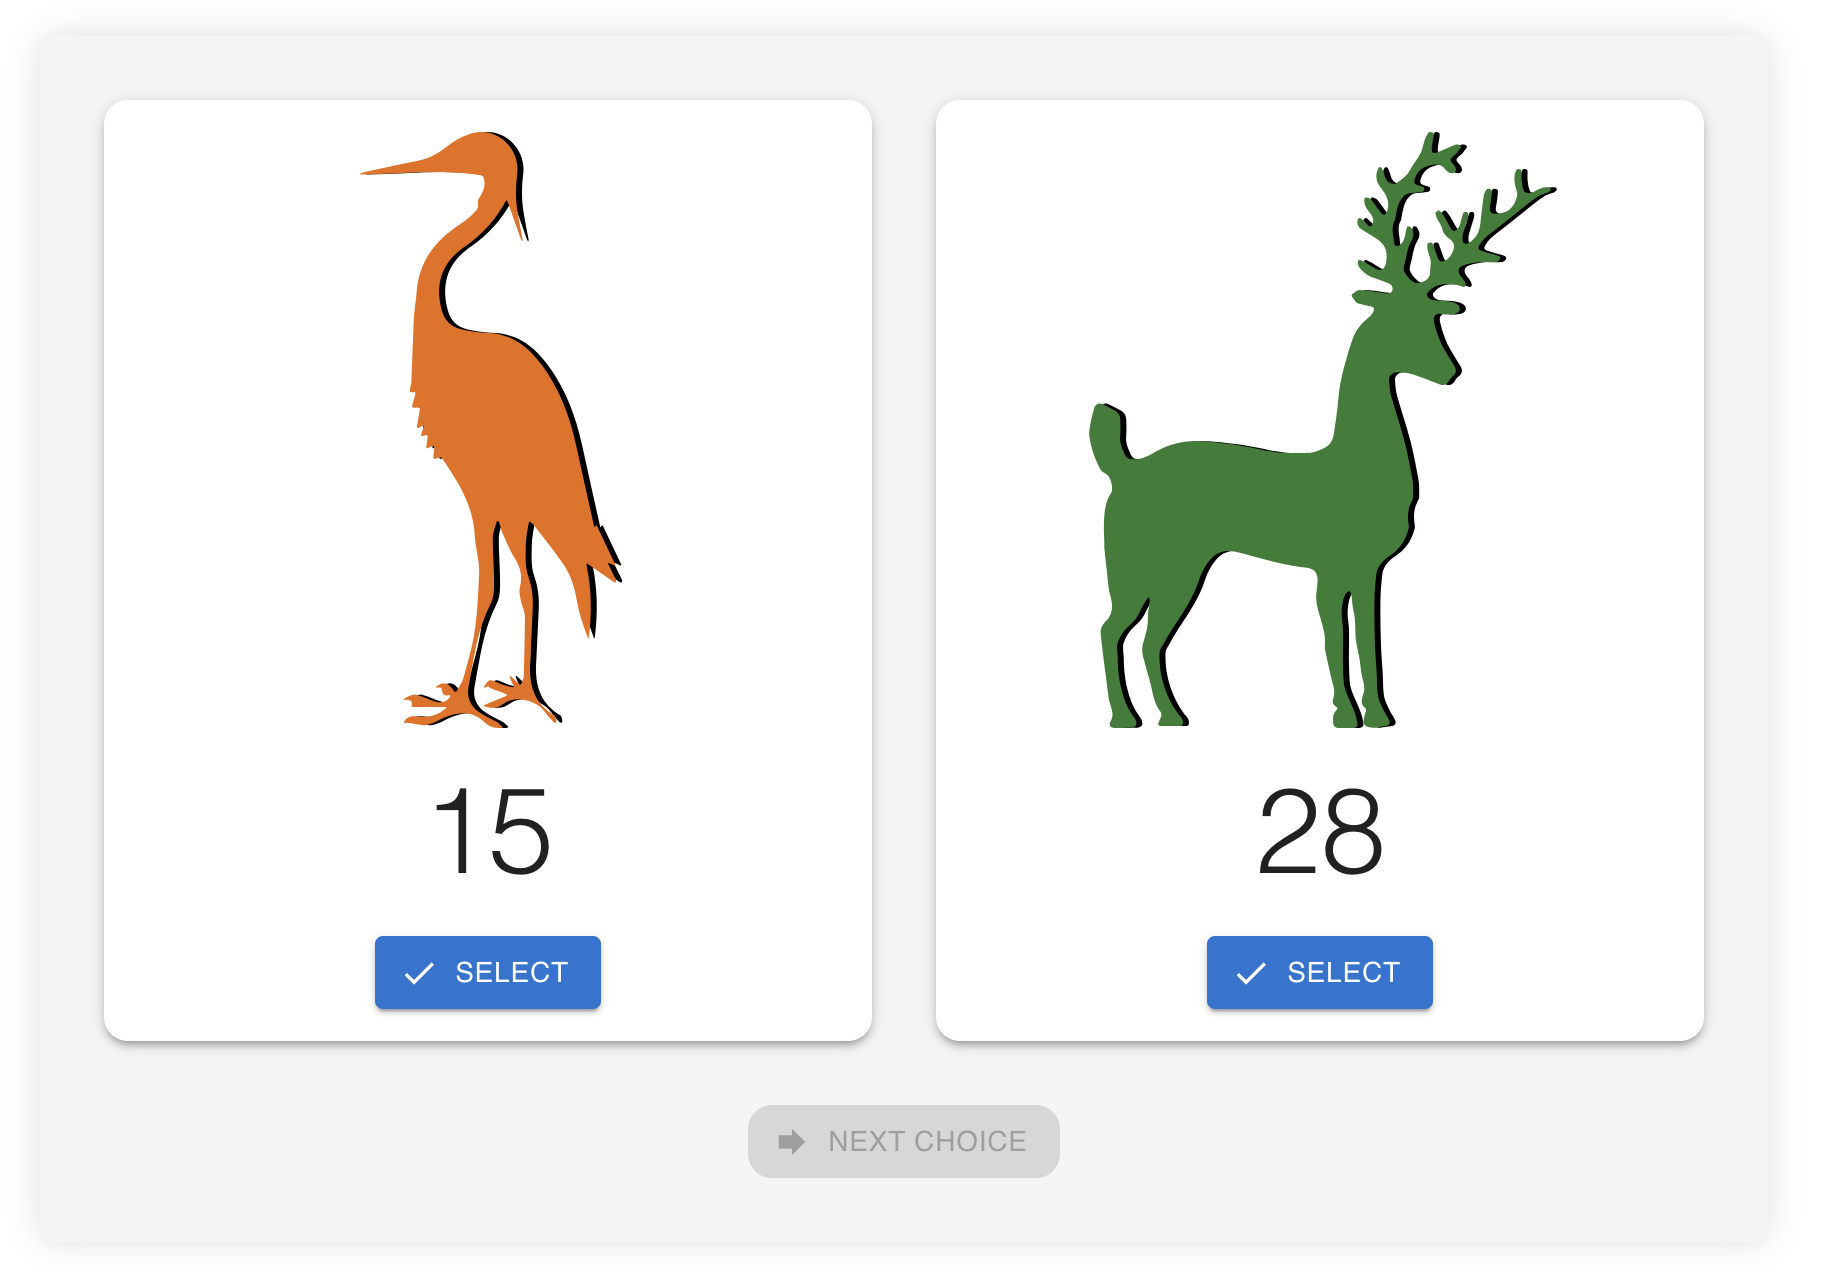

*Figure 1. Task screen. The numbers below each option indicate reward points that are associated with the option on this trial. On each trial, only one option is rewarded. The probability for one option to be rewarded is always high, while the probability for the other option to be rewarded is always low.
In the ‘stable’ block the probability stayed constant over trials. In the ‘volatile’ block, the probabilities reversed regularly. The reward-point magnitude for each option was drawn randomly and independently from the probabilities.*

The first key manipulation of the task was that there were  two types of blocks: in the ‘stable’ block, contingencies (how likely the reward was to be behind the orange or the green option) did not change. In contrast, in the ‘volatile’ block, contingencies reversed frequently. What we would predict is that people should learn more slowly (i.e., have a lower learning rate) in the stable block and faster in the volatile block.

Read through the next cell of code that sets up a function to simulate a new schedule, and to plot it. Once you have read it, run the code cell.

In [ ]:
#@title ## Generate and plot a schedule
def generate_schedule(trueProbability, rng = rng):
  '''
  Returns if option 1 (True) or option 2 (False) is rewarded on a trial, and the
  reward magnitudes on that trial.

    Parameters:
        trueProbability(float array): The probability with which option 1 is
          rewareded on each trial

    Returns:
        opt1rewarded(int array): 1 if option 1 is rewarded on a trial, 0 if
          option 2 is rewarded on a trial
        magOpt1(int array): reward points between 1 and 100 for option 1 on each
          trial
        magOpt2(int array): reward points between 1 and 100 for option 2 on each
           trial
  '''
  # We'll simulate whether opt 1 was rewarded on every trial. For each trial, we
  # generate a random number between 0 and 1. The trial is rewarded if that
  # number is smaller than trueProbability, and unrewarded otherwise.
  # The reward magnitudes are integers between 1 and 100.
  opt1Rewarded = (rng.random(len(trueProbability)) < trueProbability).astype(int)
  magOpt1 = rng.integers(1,101,len(trueProbability))
  magOpt2 = rng.integers(1,101,len(trueProbability))
  return opt1Rewarded, magOpt1, magOpt2


# true underlying reward probabilites on each trial
trueProbability = np.concatenate((np.ones(100, dtype = float)*0.75,
                                  np.ones(25,  dtype = float)*0.25,
                                  np.ones(25,  dtype = float)*0.75,
                                  np.ones(25,  dtype = float)*0.25,
                                  np.ones(25,  dtype = float)*0.75))

# generate a schedule
opt1Rewarded, magOpt1, magOpt2 = generate_schedule(trueProbability)

# plot it
plot_schedule(opt1Rewarded, trueProbability, magOpt1, magOpt2)

The top plot shows the probability over trials. It is stable for the first half of trials and volatile for the second half. The reward magnitudes in the bottom plot are drawn independently on each trial.

## Recap – Reinforcement learning model
As we saw last week, reinforcement learning can be used to describe how you might update
predictions in your mind (e.g., predictions about how likely it is that you will receive a reward if you choose a stimulus) based on experience. In this specific task, participants were trying to predict how likely they were to get a positive outcome if they chose one option or the other; and the ‘experience’
therefore was whether on each trial they received a positive outcome or not when picking a specific option.

We can now build a simple **computational model** that tries to describe the learning process that is going on in participants’ brains. This specific computational model consists of a series of simple equations:

$$
\underbrace{\delta_t}_\textrm{prediction error} = \underbrace{o_t}_\textrm{outcome} - \underbrace{p_t}_\textrm{model prediction} \tag{Equation 1}
$$

This means that on each trial $t$ the model compares the outcome $o_t$ (which is 1 if the participant receives a reward and 0 if there is no reward) to the prediction $p_t$ (which is a value between 0 and 1, e.g. 0.5 in the beginning of the experiment when you don’t yet have any experience and assume that reward and no reward are equally likely). This difference is then called the ‘(reward) prediction error’ (RPE, $\delta_t$).

$$
\underbrace{p_{t+1}}_\textrm{new prediction} = \underbrace{p_t}_\textrm{old prediction} + \underbrace{\alpha \delta_t}_\textrm{scaled prediction error} \tag{Equation 2}
$$

This second equation means: after seeing an outcome (on trial $t$), the model updates the prediction based on the prediction error computed in equation 1 to form a new prediction for the next trial (trial $t+1$). The learning rate $\alpha$ describes how quickly the model learns: the higher the learning rate, the faster. In other words, higher learning rates weight the most recent experience more heavily than low learning rates. (You can understand this by writing down the full expression for predictions on the next trial for e.g. a learning rate of 0 and a learning rate of 1). The learning rate is a so-called ‘free parameter’. This simply means that it is 'free' to be fit to the data, rather than being set to a theoretically inspired specific value. Later we will fit a reinforcement learner to real data and try, for each person, to find the learning rate that best describes their behaviour.

You might wonder why there is only one and not two predictions, as there are two distinct options. This is because only one option is rewarded in any given trial, and participants find out in every trial which option was rewarded. This is why they can just learn one prediction/probability estimate, as the inverse of one estimate has to be true for the other option (`probOpt1 = 1-probOpt2`).

# Section 1: Expanding the computational model – making decisions

The computational model above is applied to every trial of the experiment. So far, it can make predictions about how likely a reward is to be hidden behind option 1 or option 2. However, the model does not yet specify which option would be a better choice as it currently still ignores that there are different reward magnitudes (number of points) associated with each option on each trial.

## Integrating reward magnitude and probability: utility

We need to now specify how the model combines the two dimensions to derive an overall utility for each option.

Can you think of at least two different ways according to which participants might combine reward probabilities and magnitudes to figure out which option is better? Which of the different ways you have suggested is better or worse? Maybe think back to how you played the task.

→ Type your answer here

### Multiplicative utility

As an example for why you need to combine the two dimensions, imagine that you are almost 100% sure that you will receive a reward if you choose an option, but if the reward is very small (say 2 out of 100 possible points), you might nevertheless not want to pick the option. We formalize this in equation 3:

$$
\underbrace{u}_\textrm{utility} = \underbrace{m}_\textrm{reward magnitude} \times \underbrace{p}_\textrm{reward probabilty} \tag{Equation 3}
$$

Here, we define the ultity $u$ as the product of the reward probability $p$ and magnitude $m$. We can refer to this way of calculating utility as 'multiplicative utility'. We define and plot this utility function in the next code cell.

Complete the utility function in the next code cell using equation 3. Then run the cell. The 3d plot it produces can be rotated by holding and dragging your cursor.

In [ ]:
# define the utility function as per equation 3
def multiplicative_utility(mag, prob):
  return mag*prob

visualise_utility_function(multiplicative_utility)

Describe why the utility function in equation 3 produces utility of the shape shown in the above plot.

→ Type your answer here

### Additive utility

As another example, imagine that you consider reward magnitude and probability separately from each other. This is formalised in equation 4:

$$
\underbrace{u}_\textrm{utility} = \overbrace{\omega}^\textrm{magnitude weight} \times \underbrace{m}_\textrm{reward magnitude} + \overbrace{(1-\omega)}^\textrm{probability weight} \times \underbrace{p}_\textrm{reward probabilty} \tag{Equation 4}
$$

Here, reward magintude and probability are added together, which is why we refer to this type of utility as 'additive utility'. We weight up the two terms of the sum by a weight $\omega$, which is $0 \leq \omega \leq 1$. To ensure that probability and magnitude are on the same scale, we assume that the magnitude has been normalised to be on a range from $0$ to $1$ (i.e., it has been divided by $100$).  

At the extreme, you might even consider only reward magnitude or only reward probaility when making your choices. This can be modelled by setting $\omega$ to which values?

→ Type your answer here

Run the next code cell that visualises additive utility.

In [ ]:
# additive utility function as per equation 4
def additive_utility(mag, prob, omega):
  return (omega*(mag/100) + (1-omega)*prob)*100

visualise_utility_function(additive_utility, omega = True)

Change the value of omega using the slider to see how it affects the shape of the utility function. Describe why the utility function in equation 4 produces utility of the shape shown in the above plot.

→ Type your answer here

What are the major differences in the shape of multiplicative and additive utility?

→ Type your answer here

## Making choices

In general, the model should prefer the option with the higher utility, but how can we make it select a specific option on each trial? Intuitively, you might want to say, always pick the option with the higher utility even if the difference is small. This would be a deterministic decision rule and given our current task would be the optimal choice strategy. However, we know that this is not how real participants behave; they behave stochastically, i.e., they sometimes make mistakes and instead pick options with lower value. This is particularly pronounced when the two options’ utilities are similar, i.e., when the decision is more difficult.

Why do you think that in the current scenario it is always best to pick the option with the higher utility? And, given your answer, can you think of another scenario in which a better strategy would be to sometimes choose the alternative option?


→ Type your answer here

The figure below illustrates the difference between a deterministic (red) and a stochastic (black) decision rule.

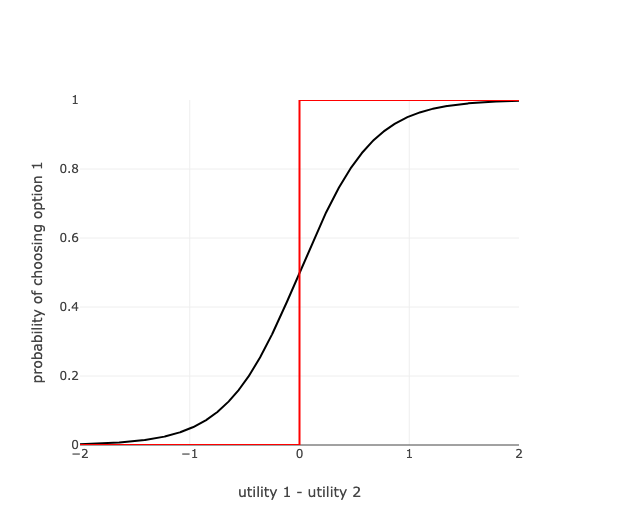

Can you describe what you see in the figure?

→ Type your answer here

### The softmax function

A mathematical function that produces this shape of the
stochastic decision rule is the 'logistic function'; it is also
called a ‘softmax decision rule’ or a 'sigmoid function':

$$
\underbrace{P(c_1)}_\textrm{probability of choosing option 1} = \frac{e^{\beta u_1}}{e^{\beta u_1} + e^{\beta u_2}} = \frac{1}{1+ e^{-\beta(u_1 - u_2)}} \tag{Equation 5}
$$

Here, $u_1$ is the utility associated with option 1, and $u_2$ the utility of option 2. $\beta$ is a free parameter, also
called the 'inverse temperature'. The higher the inverse
temperature, the 'steeper' the softmax is (i.e., the less
stochastic). The reason it is called 'inverse temperature' is an allusion to thermodynamics: you can think of it as the higher the temperature (i.e. the lower the inverse temperature), the faster particles move around, i.e., the more noise there is or the more stochastic behavior becomes.

Complete the softmax function in the next code cell as shown in equation 5. Hint: the $e$ function is implemented in python as `np.exp()`. When you have completed the function, run the cell. It should produce a plot similar to the one pictured above.   

In [ ]:
# softmax function as per equation 5
def softmax(utility1, utility2, beta):
  return np.exp(utility1*beta)/(np.exp(utility1*beta) + np.exp(utility2*beta))

visualise_softmax(softmax)


To have a look at what the effect of changing the inverse temperature is, change the beta slider to different values. What do you notice as you change the inverse temperature?

→ Type your answer here

### Using utility and the softmax function with the RL model

We can now extend the script which we wrote during the last session to simulate an RL model such that it also combines reward magnitudes and probabilities using a utility function. The script then compares the utility of both options using a softmax function to calculate the probability of choosing option 1 for each trial.

Run the next code cell to simulate the RL model. In the resulting plot, you can change the values of $\alpha$ and $\beta$ to see how it affects the model predictions. If the plot gets too busy and you want to focus on particular elements of the model, you can switch on and off what is being displayed by clicking on the corresponding legend entries.

In [ ]:
#@title ### Simulating and visualising the RL model with multiplicative utility
def simulate_RL_model(opt1Rewarded,
                      magOpt1,
                      magOpt2,
                      alpha,
                      beta,
                      *additonalParameters,
                      startingProb = 0.5,
                      utility_function = multiplicative_utility,
                      choice_function = softmax):
  '''
  Returns how likely option 1 is rewarded on each trial, the probability of
  choosing option 1 on a trial, and a simulated choice for each trial

    Parameters:
        opt1rewarded(bool array): True if option 1 is rewarded on a trial, False
          if option 2 is rewarded on a trial.
        magOpt1(int array): reward points between 1 and 100 for option 1 on each
          trial
        magOpt2(int array): reward points between 1 and 100 for option 2 on each
           trial
        alpha(float): fixed learning rate, greater than 0, less than/equal to 1
        beta(float): fixed inverse temperature, greater than 0
        *additionalParameters(float, optional): other parameters to pass onto
          the utility function, for example, the omega used in additive utility.
        startingProb(float): starting probability (defaults to 0.5).
        utility_function(function): what utility function to use to combine
          reward magnitude and probability. Defaults to multiplicative_utility
        choice_function(function): what choice function to use to decide
          between utility1 and utility2. Has free parameter beta. Defaults
          to softmax.

    Returns:
        probOpt1(float array): how likely option 1 is rewarded on each trial
          according to the RL model.
        choiceProb1(float array): the probability of choosing option 1 on each
          trial when combining information about magnitude and probability
  '''

  # check that alpha has been set appropriately
  assert alpha > 0, 'Learning rate (alpha) must be greater than 0'
  assert alpha <= 1,'Learning rate (alpha) must be less than or equal to 1'

  # check that inverse temperateure has been set appropriately
  assert beta >= 0, 'beta must be greater or equal than 0'

  # check that startingProb has been set appropriately
  assert startingProb >= 0, 'startingProb must be greater or equal than 0'
  assert startingProb <= 1, 'startingProb must be less than or equal to 1'

  # calculate the number of trials
  nTrials = len(opt1Rewarded)

  # pre-create some vectors we're going to assign into
  probOpt1    = np.zeros(nTrials, dtype = float)
  delta       = np.zeros(nTrials, dtype = float)
  choiceProb1 = np.zeros(nTrials, dtype = float)

  # set the first trial's prediction to be equal to the starting probability
  probOpt1[0] = startingProb

  for t in range(nTrials-1):
        # calculate the utility of the two options. *additionalParameters would only be needed
        # if the utility function has >2 inputs, which is not the case for multiplicative
        # utility.
        utility1 = utility_function(magOpt1[t], probOpt1[t], *additonalParameters)
        utility2 = utility_function(magOpt2[t], (1 - probOpt1[t]), *additonalParameters)

        # get the probability of making choice 1
        choiceProb1[t] = choice_function(utility1, utility2, beta)

        # calculate the prediction error
        delta[t] = opt1Rewarded[t] - probOpt1[t]

        # update the probability of option 1 being rewarded
        probOpt1[t+1] = probOpt1[t] + alpha*delta[t]

  return probOpt1, choiceProb1

# visualise the simulated RL model
plot_interactive_RL_model(simulate_RL_model, multiplicative_utility, opt1Rewarded, magOpt1, magOpt2, trueProbability)

As you change $\alpha$ and $\beta$, what do you notice about the choice probability? Why is it different from the reward predictions? Both in terms of that it can reach up to 1, rather than plateauing at about 0.8 and that sometimes predictions can be high (i.e., the model believes that it is
likely that the reward will be behind option A), but choice probability is low (i.e., the model is more likely to choose option 2)? If the plot is too crowded, you can switch off elements by clicking on the corresponding entry in the legend on the right.

→ Type your answer here

Next, we make the same plot but assuming an additive utility function. Run the next code cell now and again change the parameters. Why does the utility function take on the shape it does as you change $\omega$ to the extremes of 0 and 1? What does this mean for the choice probabilities? And how does $\omega$ interact with $\alpha$ and $\beta$? Again, if the plot is too crowded you can temporarily switch off elements by clicking on the corresponding entry in the legend on the right.

→ Type your answer here

In [ ]:
#@title ### Simulating and visualising the RL model with additive utility

plot_interactive_RL_model(simulate_RL_model, additive_utility, opt1Rewarded, magOpt1, magOpt2, trueProbability, omega = True)

The model's choice probabilities are crucial for fitting the model to the data (considered in detail in the next session) and for making simulations (next section in today's session). In short, when fitting a model we ask, given a participant's choices, what their model parameters must have been to produce
these choices. Python does this by changing the model parameters (here learning rate $\alpha$, inverse temperature $\beta$, and optionally $\omega$ for additive utility) until the choice probabilities match participant's actual choices as closely as possible.

# Section 2: Parameter recovery

## Creating simulations from the model

You now know all the key equations that define our computational model. Before fitting this model to the data from real participants (next session), we will use the model to simulate data. This involves the following steps:


1. give your computational model the same sequence of trials that you want to give to your real participants (in our case, the outcomes [reward behind option 1 or option 2] and the reward
magnitudes)
2. pick values for the parameters (i.e., for the learning rates for the stable and the volatile block)
3. use the model with those chosen parameters to simulate choices (i.e., meaning that you know the ground truth that we don’t know for real participants)
4. use the same analysis technique you want to use for the real data to analyse the simulated choices (i.e., fit a reinforcement learning model to obtain 'fitted parameters').
5. compare the fitted to the simulated parameters (i.e., they should be more or less the same, but see below for why this might not be the case)
6. simulate parameters that capture your experimental hypothesis (i.e., lower learning rate in the stable than the volatile phase) and check whether the fitted parameters would support that hypothesis.

This shows a visual overview of the choice simulation process (we will come back to this in Session 3 for fitting data from participants which is why the blue box says real or simulated data - today we focus on simulated i.e., synthetic data only):


Why is it so important for you to run simulations rather than just fitting your model to the data? You can use the simulations to validate your experiment and your analysis method. For example, you might find that the fitted parameters are very different from the simulated parameters. This tells you that there is a serious problem with either how you have designed your experiment or your analysis approach. For example, it could be that you have not included enough trials in your experiment; or it could be that you have made a coding error somewhere and accidentally always presented the higher reward magnitude on top of the option that also had the higher probability; or it could be that the
range of reward magnitudes and probabilities you picked is inappropriate (e.g., imagine that the probabilities were too close to 50% and that participants only use the reward magnitudes to guide their choices).

For the possibilities described above, can you imagine why this might lead to the fitted parameters not matching the ones used to simulate the choices?

→ Type your answer here

Can you think of how you could plot the fitted and the simulated parameters to check whether they are similar? And what kind of statistical measure would you use to quantify their 'similarity'?

→ Type your answer here

The second way in which you would want to use simulations is to check that your experiment is capable of confirming or disconfirming your experimental hypothesis.

How would you simulate data to check that the model is capable of testing our hypothesis that learning rates are lower in the stable than the volatile block? Hint: you will need to simulate data for two possibilities.

→ Type your answer here

## Model simulations

We have now almost completed all steps to create simulations: we have generated a schedule (last session), we have used a model with parameter values of our choosing (for learning rate and inverse temperature) to create choice probabilities. We now need to translate them into actual choices. In other words, for each trial, we now have a probability that the model (i.e.,
simulated participant) should choose option A over B; however, in our actual task, on each trial participants need to then translate this choice probability into pressing a single button. For the simulations we will run for the remainder of this session, we will assume that our simulated participants use multiplicative utility.

To generate random choices from the model, we will use a procedure similar to how translated a reward probability into an actual reward outcome when making a schedule in session 1. That is, we will use the `rng.random()` function, which generates a random number between 0 and 1, and compare this random number against a choice probability. For example, assume the choice probability on a trial is 0.8. If we do a comparison such as shown in the next code cell, then this comparison should, by chance, give you the value of 'true' in 80% of cases, and 'false' in 20% of cases. You can verify this by running the code cell repeatedly.



In [ ]:
0.8 > rng.random()

NameError: ignored

Using this logic, complete the code below and then run it. You should obtain an updated version of the previous figure that now also plots the simulated choices. Again, if the figure is too crowded, you can hide elements by clicking on the corresponding entry in the figure legend. What do you notice about the relationship between choice probability (red) and the actual choices?

In [ ]:
# set parameters for the simulation
alpha = 0.3
beta  = 0.05

# run the RL model
probOpt1, choiceProb1 = simulate_RL_model(opt1Rewarded, magOpt1, magOpt2, alpha, beta)

nTrials = len(probOpt1)
# COMPLETE THIS LINE
# simulate a choice according to the probability
choice1 = np.zeros(nTrials, dtype = int)
for t in range(nTrials):
  choice1[t] = choiceProb1[t] > rng.random()

# plot the model output
plot_schedule(opt1Rewarded, trueProbability, magOpt1, magOpt2, probOpt1, choiceProb1, choice1)

→ Type your answer here

To help you relate what we have looked at so far to data from our real participant, think about which line in the figure above is directly measured from a real participant? And which ones can we get only as latent parameters from our model?

→ Type your answer here

## Fitting models using maximum likelihood


### The likelihood function

Given choice data, we can ask which model parameters best describe these choices. To do this, we need to estimate the *likelihood* of the choices being produced from a model with specific parameter values. In our case, the trial-by-trial likelihood is directly given by the softmax function of the utilities associated with both options on that trial (i.e. the choice probability). Thus, to calculate the likelihood for given values of $\alpha$ and $\beta$, we need to calculate the choice probability for each trial and compare whether this matches the actual choices a (simulated) participant made. If the choice probability is close to the actual choice, the likelihood is high, and if the choice probbility is far from the actual choice, then the choice probability is low.

In other words, if you were to move the sliders for the model parameters $\alpha$ and $\beta$ around until the choice probability is as close to the choices as possible, then you would try to find the model with the highest likelihood.

### Grid search

The next code cell simulates a synthetic dataset and then tries to recover the values of $\alpha$ and $\beta$ that were used for the simulation. To do so, the script tries out a range of $\alpha$ and $\beta$ values in a grid, and computes the likelihood for each $\alpha$, $\beta$ pair. This way of trying to find the parameters with the highest likelihood is called a 'grid search'.

The function also computes the log likelihood. Calculating the log likelihood rather than the likelihood is more convenient for mutliple reason. One of these reasons is that instead of having to multiply the likelihood of each individual trial, we can sum them up (as logarithms turn products into sums).

Run the next code cell now. This might take a bit as a grid search needs to try out many different parameter values. The two plots that the code produces are the likelihood and log likelihood landscapes for different values of $\alpha$ and $\beta$. The aim of maximum liklihood estimation is to find the peak of these landscapes. Just as with previous 3d plots, you can rotate the figures by holding and dragging your cursor. Describe what the likelihood landscape tells us about the recovered values of $\alpha$ and $\beta$. Can the landscape also be used to inform us about the uncertainty in our estimates of $\alpha$ and $\beta$?

In [ ]:
# set the true parameters for the simulation
alpha = 0.3
beta  = 0.2

# simulate a schedule
opt1Rewarded, magOpt1, magOpt2 = generate_schedule(trueProbability)

# get the RL model estimates
probOpt1, choiceProb1 = simulate_RL_model(opt1Rewarded, magOpt1, magOpt2, alpha, beta)

# simulate random choices based on the model output
choice1 = (choiceProb1 > rng.random(nTrials)).astype(int)

# calculate and plot the likelihood for a range of alpha and beta pairs
plot_likelihood_landscapes(opt1Rewarded, magOpt1, magOpt2, choice1)



→ Type your answer here

Both the likelihood and the log likelihood have the same peak, which can be visually confirmed by examining the two figures above. Can you think of reasons why it makes more sense to work with a log likelihood landscape rather than a likelihood landscape? And vice versa, when could it be more sensible to work with a likelihood rather than a log likelihood landscape?

→ Type your answer here

### Using an algorithm to find the maximum likilihood parameter estimates

Calculating the full log likelihood landscape is computationally expensive because we have to calculate the log likelihood for each parameter combination. This becomes especially problematic as we introduce more parameters, because the number of possible parameter combinations grows exponentially with the number of paramters. Therefore, if we want to find the maximum of the landscape, it is sensible to consider other means of getting there. An intuitiv way of approaching this problem is to start at a random point on the likelihood landscape, (roughly) determine which direction is upwards, and to take a step into that direction. Once that step has been taken, you readjust your trajectory and take another step that takes you further up the hill. This, in a somewhat handwavy way, is how most algorithms attempt to find the maximum of this function.

Run the next code cell now (the code will still take a while to run because it also computes a grid search to visualise the walk on the likelihood landscape).

In [ ]:
plot_loglikelihood_trajectory(opt1Rewarded, magOpt1, magOpt2, choice1)

The above plot shows the trajectory the algorithm took along the likelhood landscape until it reached the peak.

Describe why using this algorithm is more efficient for finding the maximum likelihood parameter values rather than performing grid search.

→ Type your answer here

## Running a parameter recovery

Now that we understand how in a simulation choice probabilities are translated into actual choices, and how we can estimate the paramters underlying (simulated) data, let's return to using simulations to check that our task and analysis methods are appropriate.

The next code cell runs simulations (i.e., it generates 'actual choices') for a range of learning rates (alphas) and choice stochasticity values (inverse temperatures; beta). The code uses the model that we've developed above. How could you decide what ranges of learning rates and inverse temperatures to use for the simulations?

→ Type your answer here

The script then fits the simulated choices to obtain 'fitted parameters'. Look at the figures that are produced by running the next code cell.

In [ ]:
#@title #### Simulating choices and recovering parameters

# the parameter ranges we want to simulate from
simulatedAlphaRange = np.arange(0.01, 0.7, 0.05)
simulatedBetaRange  = np.arange(0.01, 0.4, 0.05)

# run the parameter recovery
recoveryData = run_paramterer_recovery(
    simulatedAlphaRange, # what alpha values to try out
    simulatedBetaRange,  # what beta values to try out
    simulate_RL_model,   # the function we use to simulate the RL model
    generate_schedule,   # the function we use to generate a schedule
    trueProbability,     # the reward probabilities the schedule is generated from
    rng,                 # the random number generator we use
    )

plot_recovered_parameters(recoveryData)

'simulating and fitting subject 0/112'

'simulating and fitting subject 10/112'

'simulating and fitting subject 20/112'

'simulating and fitting subject 30/112'

'simulating and fitting subject 40/112'

'simulating and fitting subject 50/112'

'simulating and fitting subject 60/112'

'simulating and fitting subject 70/112'

'simulating and fitting subject 80/112'

'simulating and fitting subject 90/112'

'simulating and fitting subject 100/112'

'simulating and fitting subject 110/112'

This figure shows correlations between simulated and fitted parameters. What do you observe and does it suggest that our task has a problem or not?

→ Type your answer here

To better understand why the recovery of the learning rates had some strange outlier values, you can hover over simulated and recoverd alpha values to see the corresponding inverse temperature. How do you interpret what you find and what does it mean for analyzing our real participants' data? Would you be satisfied with the recovery or concerned for going ahead with an experiment in real participants?

→ Type your answer here

### Testing for presence and absence of our effect of interest

The aim of the next simulation is to check whether our experiment could detect our manipulation of interest if it indeed existed in the real data and at the same time would not lead to a false positive if it did not exist. You can find out more about this procedure of 'model falsification' by looking at Palminteri et al. (2017) in this week's reading list. To verify this is the case in our task, we will simulate two sets of participants, one group in which there is a difference between the learning rates in the two blocks (lower in the stable phase) and one group in which there is no difference between the learning rates in stable and volatile blocks.

Run the next code cell now, which randomly generates distributions of $\alpha$, once with a difference between stable and volatile blocks and once without.


In [ ]:
#@title #### Visualising the simulated parameter distributions

nSimulatedSubjects = 100

# generate random simulation paramters
stableAlphasDifference     = rng.beta(10, 50, nSimulatedSubjects)
volatileAlphasDifference   = rng.beta(15, 45, nSimulatedSubjects)
stableAlphasNoDifference   = rng.beta(13, 47, nSimulatedSubjects)
volatileAlphasNoDifference = stableAlphasNoDifference
betas = rng.exponential(.1, nSimulatedSubjects) + 0.05

# specify the reward probabilities for both session types
trueProbabilityStable = np.ones(100, dtype = float)*0.75
trueProbabilityVolatile = np.concatenate((
                                  np.ones(25,  dtype = float)*0.25,
                                  np.ones(25,  dtype = float)*0.75,
                                  np.ones(25,  dtype = float)*0.25,
                                  np.ones(25,  dtype = float)*0.75))

# plot the simulated paramters as histograms
visualise_alpha_difference(stableAlphasDifference, volatileAlphasDifference, 'simulated learning rates with a difference between blocks')
visualise_alpha_difference(stableAlphasNoDifference, volatileAlphasNoDifference, 'simulated learning rates with no difference between blocks')


Why is it important to make a simulation in which there is no difference between the learning rates in the two blocks (rather than just the simulation with different learning rates in the two blocks)?

→ Type your answer here

The next code cell simulates and recovers participant data assuming that there is a difference in learning rates. Run that cell now.

In [ ]:
#@title #### Parameter recovery with difference between blocks

recoveryDataDifference = run_paramterer_recovery_with_difference(
    stableAlphasDifference,   # alpha values in the stable condition
    volatileAlphasDifference, # alpha values in the volatile condition
    betas,                    # beta values in both conditions
    simulate_RL_model,        # the function we use to simulate the RL model
    generate_schedule,        # the function we use to generate a schedule
    trueProbabilityStable,    # the reward probabilities in the stable condition
    trueProbabilityVolatile,  # the reward probabilities in the volatile condition
    rng                       # the random number generator we use
    )

visualise_alpha_difference(recoveryDataDifference["alpha stable"], recoveryDataDifference["alpha volatile"], 'recovered learning rates with an underlying difference between blocks')

'fitting subject 0/100'

'fitting subject 10/100'

'fitting subject 20/100'

'fitting subject 30/100'

'fitting subject 40/100'

'fitting subject 50/100'

'fitting subject 60/100'

'fitting subject 70/100'

'fitting subject 80/100'

'fitting subject 90/100'

Now, in the next cell, we run a simulation where there is no difference in the simulated dataset but we still fit it assuming that there is a difference. Run that cell now.

In [ ]:
#@title #### Parameter recovery with no difference between blocks

recoveryDataNoDifference = run_paramterer_recovery_with_difference(
    stableAlphasNoDifference,   # alpha values in the stable condition
    volatileAlphasNoDifference, # alpha values in the volatile condition
    betas,                      # beta values in both conditions
    simulate_RL_model,          # the function we use to simulate the RL model
    generate_schedule,          # the function we use to generate a schedule
    trueProbabilityStable,      # the reward probabilities in the stable condition
    trueProbabilityVolatile,    # the reward probabilities in the volatile condition
    rng                         # the random number generator we use
    )

visualise_alpha_difference(recoveryDataNoDifference["alpha stable"], recoveryDataNoDifference["alpha volatile"], 'recovered learning rates with no underlying difference between blocks')

What do you notice when comparing the previous two plots? Does it suggest that our experiment will be able to find a difference in learning rate between volatile and stable blocks if it exists, but not lead to a false positive finding (i.e. suggest that there is a difference when in fact there is none)? Why was it important to make a simulation in which there was no difference between the learning rates in the two blocks (rather than just the simulation with different learning rates in the two blocks)?

→ Type your answer here